In [1]:
%matplotlib inline

import os 
import sys 
import time
import hashlib

from datetime  import datetime 

import numpy as np  # learn 
import pandas as pd # learn
from pandas import *
from numpy import *

from scipy import stats # look at scipy
from scipy import linalg
from scipy import *
 
import matplotlib as mplt # learn matplolib 
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

# import seaborn as sns 
# sns.set_style("whitegrid")
# sns.set(rc={"figure.figsize": (14, 6)})

import IPython
from IPython.display import display

import matplotlib
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
 
# import sklearn as sk
import itertools

# from pyspark import SparkContext, SparkConf
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from pyspark.mllib.regression import LabeledPoint

from keras.models import Sequential 
from keras.layers.core import Dense, Activation, TimeDistributedDense, Dropout
from keras.layers.recurrent import LSTM
from keras.optimizers import *
# RMSprop, Adadelta
from keras.regularizers import l2, activity_l2

import scipy.stats as st

from random import random
import pickle

# http://sebastianruder.com/optimizing-gradient-descent/
# https://leemendelowitz.github.io/blog/how-does-python-find-packages.html

Using Theano backend.


In [2]:
# block1: Training dataset

# load and extract yahoo data
# choose the data in files real_11-20, which contains a time series (data point 3000 - 10000) with mediate 
#  outlier magnitude 

#  this dataset will be used for realtime training RNN 
# 6,13,15,11,22,29,56,31,39,57,43,65, 55,62


# 13 23 29 44
# final chosen one: 2,3

figsize= ( 10,5)

def value_drift_observe( ts, file_name ):
    valDrift =  [ ts[i+1]-ts[i] for i in range(len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= figsize
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, len(ts)+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in ' + file_name )
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend() 
    
def diff_drift_observe( ts, file_name ):
    valDrift =  [ (abs(ts[i+1]-ts[i])+abs(ts[i-1]-ts[i]))/2.0 for i in range(1,len(ts)-1) ]
    
    fig = plt.figure()
    figure_size= figsize
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, len(ts)+10])
#     axes.set_ylim([-2000,maxval+2000])

    plt.plot( range(1,len(ts)-1 ) ,  valDrift, label='value drifts: x_t - t_(t-1)' )
# plt.plot( list( clean_tdf['value']), color='g' )
# plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')
# plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


# axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
# axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Value drift in ' + file_name )
    plt.ylabel('Value')
    plt.xlabel('Time')
# plt.legend( loc='upper left',fontsize=12 )
    plt.legend()
    
def yahoo_load_data( fileNo,  dta_folder):
    
    is_clean=0
    
    tmpdf= pd.read_csv( dta_folder + str(fileNo) + ".csv")
    tmpdf.drop('timestamp', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamp', tmp_col)
    tdf= tmpdf
        
    maxval= max(tdf['value'])
    minval= min(tdf['value'])

    outlier_tdf= tdf[ tdf['is_anomaly'] ==1  ]
    clean_tdf =  tdf[ tdf['is_anomaly'] ==0  ]

    if is_clean==1:
        ts= clean_tdf['value']
    else:
        ts= tdf['value']
    
    ts_flag= list(tdf['is_anomaly'])

#     print "size of clean data:",clean_tdf.shape
#     print "size of noisy data:", ts.shape, len(ts_flag)
#     print outlier_tdf
    
    # .............plot.................

    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( list( tdf['value']), label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
             label='Outliers', marker='+')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))


    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Yahoo Real Data ('+'files: real_' + str(fileNo) +')')
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( list(tdf['value']), 'real_'+str(fileNo) )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
    return ts, ts_flag
    
    
# ax.annotate('local max', xy=(3, 1),  xycoords='data',
#             xytext=(0.8, 0.95), textcoords='axes fraction',
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             horizontalalignment='right', verticalalignment='top',
#             )

def plot_outlier( ts_t, ts_val, out_t, out_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val ,label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers')
    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

#     value_drift_observe( ts_val , dataset_name )  

    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_outlier_cp( ts_t, ts_val, out_t, out_val, cp_t,cp_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val, label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )
    plt.scatter( out_t ,out_val, color='red',label='Outliers',s=60)
    plt.scatter( cp_t ,cp_val, color='green',label='Change-Points',s=100, marker='*')

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( ts_val , dataset_name)  
    diff_drift_observe( ts_val , dataset_name)  

    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def plot_plain(ts_t, ts_val, dataset_name):
    
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    axes = plt.gca()
#     axes.set_xlim([1, tdf.shape[0]+10])
    # axes.set_ylim([-2000,maxval+2000])

    plt.plot( ts_t, ts_val, label='Normal data' )
    # plt.plot( list( clean_tdf['value']), color='g' )

    # plt.xticks([1,2,3,4,5], ['5','10','15','20','25'] )
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

    # axes.xaxis.set_ticks( ['5m', '10m', '15m','20m'] ) 
    # axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title(dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')
    # plt.legend( loc='upper left',fontsize=12 )
    plt.legend(loc='upper left')
    #     bbox_to_anchor=(0., 1.0, 1., .10),
    #            loc=0,
    #            ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font , numpoints=1 )

    value_drift_observe( ts_val , dataset_name )  
    
    #     fig.savefig('example_ts.pdf', format='pdf', bbox_inches='tight')
    
def load_dataset(file_path, column, st,ed, seperator, drop_na_bool):
    
    tmpdf= pd.read_csv( file_path , sep=seperator)

    if drop_na_bool == True:
        tmpdf = tmpdf.dropna(axis=0)
    print tmpdf.shape

    tmplist = list(tmpdf[ column ])
    tmplist = [float(i)  for i in tmplist]
    
    tmplist = tmplist[st:ed]
    
    tpoints= range(len( tmplist ))
    
    return tmplist, tpoints


def yahooSyn_load_data_plot( fileNo,  dta_folder):
    
    tmpdf= pd.read_csv( dta_folder + str(fileNo) + ".csv")
    tmpdf.drop('timestamps', axis=1, inplace=True)
    tmp_col=  range( 1, tmpdf.shape[0]+1 ) 
    tmpdf.insert(0, 'timestamps', tmp_col)
    tdf= tmpdf
    
#     print "size of noisy data:", tdf.shape
    
    maxval= max(tdf['value'])
    minval= min(tdf['value'])
    outliers= tdf[ tdf['anomaly'] ==1  ]
    cps= tdf[ tdf['changepoint'] ==1  ]
    
    ts_flag= list(tdf['anomaly'])

    figure_size= figsize
    legend_font= 8.5
    fig = plt.figure()
    fig.set_size_inches( figure_size )

    plt.plot( list( tdf['value']), label='Normal data' )
    plt.scatter( list(outliers['timestamps']),list(outliers['value']), color='red',\
                label='Outliers'  )
#     plt.scatter( list(cps['timestamps']),list(cps['value']), color='green',\
#                 label='Changepoints'  )
    for i in list(cps['timestamps']):
        plt.axvline(x=i, color='k',ls='dashed')
    
    axes = plt.gca()
    axes.set_xlim([1, tdf.shape[0]+10])
  
    plt.title('Yahoo Real Data ('+'files: real_' + str(fileNo) +')')
    plt.ylabel('Value')
    plt.xlabel('Time (seconds)')
    plt.legend()
#     plt.legend(loc=0, ncol=5, mode="expand", borderaxespad=0., fontsize= legend_font 
# , numpoints=1 )
    
    value_drift_observe( list(tdf['value']), 'real_'+str(fileNo) )

    diff_drift_observe( list(tdf['value']), 'real_'+str(fileNo) )  

    
    return tdf['value'], ts_flag, list(cps['timestamps'])


# TODO
def outlier_detection( ts_list ):
    
    tmplen= len(ts_list)
    
#     for i in range(tmplen):


    return ts_flag

(9997, 9)
(9471, 17)
(16653, 7)
(162500, 5)
(9752, 7)


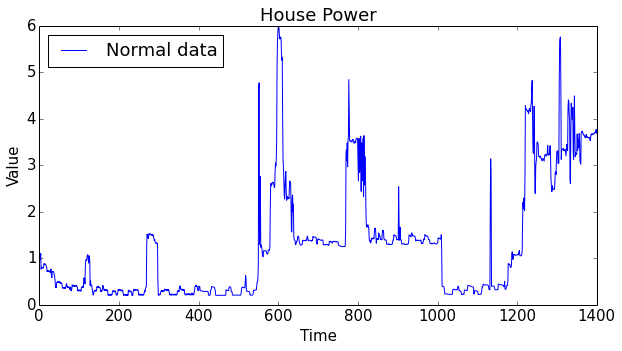

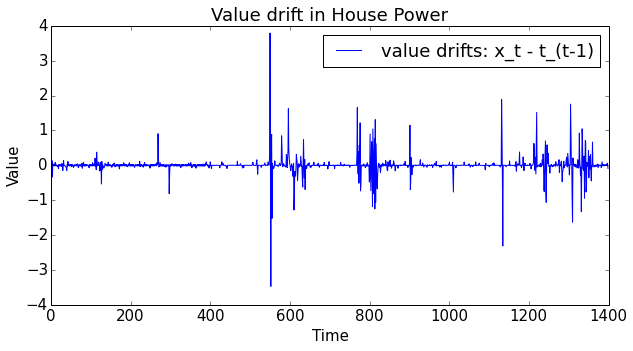

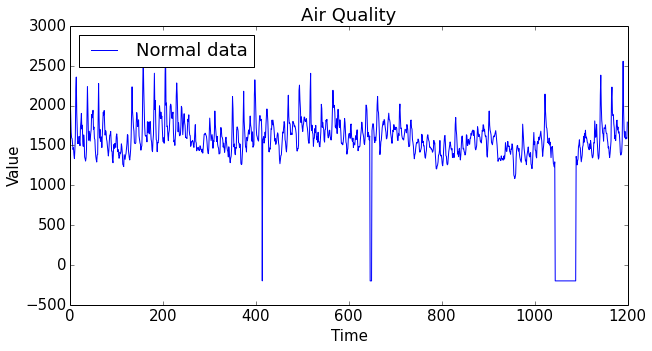

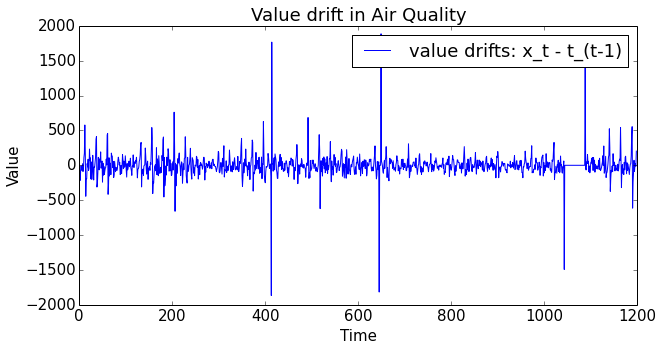

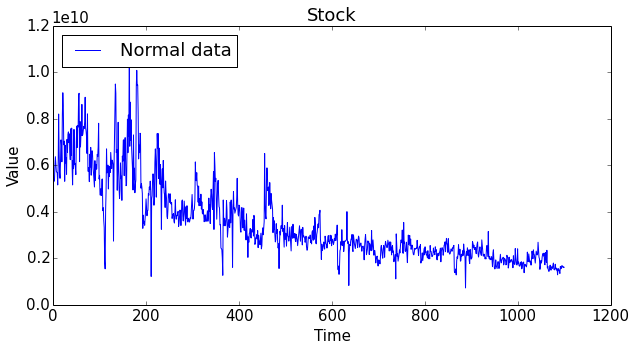

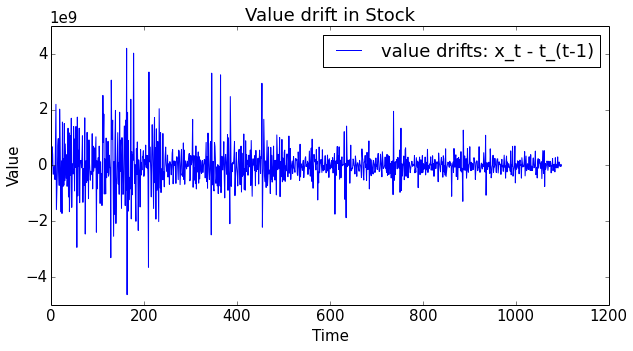

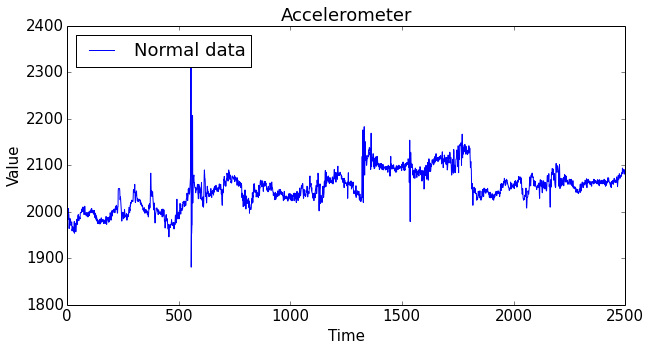

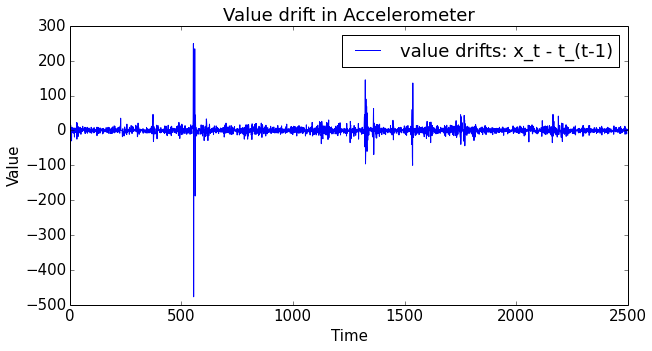

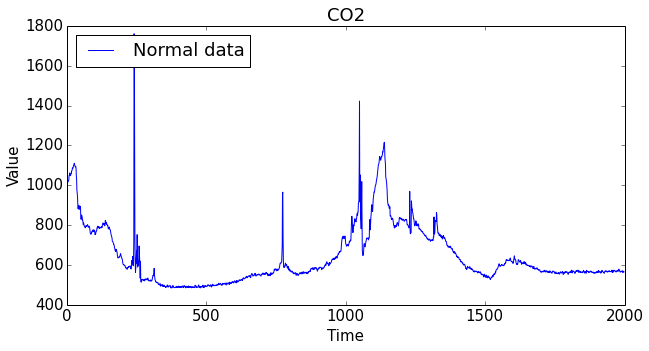

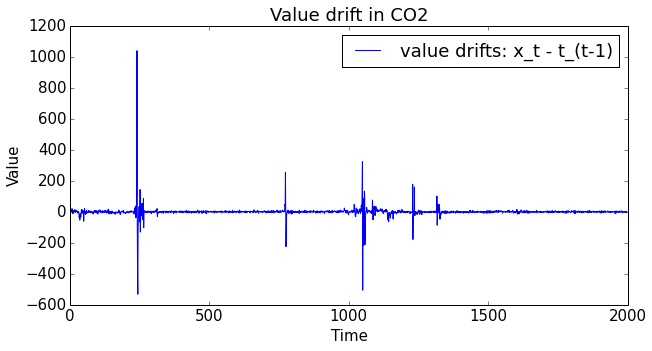

In [8]:
#  unlabelled data

ts_arr=[] 
tp_arr=[]
ts_flag_arr=[]
ts_cpt_arr=[]
yrange_arr=[]

dataset_names=[ "House Power","Air Quality", "Stock","Accelerometer", "CO2"  ]

tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+"house-power.csv", "Global_active_power", 4600, 6000, ';'\
                                 ,True)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([0, 6]  )

tmpts,tmpt= load_dataset("/home/guo/rnn_changePoint/dataset/"+"air-quality.csv","PT08.S4(NO2)", 3000,4200,';', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([-500, 3000]  )

tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+"stock.csv","Volume",1700, 2800,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([0, 1.2e10]  )

tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+\
                            "Activity Recognition from Single Chest-Mounted Accelerometer/"
                              +"1.csv",  '2153' ,147500,150000 ,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([1800, 2400]  )





tmpts,tmpt = load_dataset("/home/guo/rnn_changePoint/dataset/"+\
                            "occupancy_data/"
                              +"datatest2.txt","CO2" , 1, 2000 ,',', False)

ts_arr.append( tmpts ) 
tp_arr.append(  tmpt)
ts_flag_arr.append( [0]*(len( tmpts) )  )
ts_cpt_arr.append([])
yrange_arr.append([400, 1800]  )





#  plot unlabelled data
tmpcnt = len(ts_arr)
for i in range(tmpcnt):
    plot_plain(tp_arr[i] , ts_arr[i], dataset_names[i])

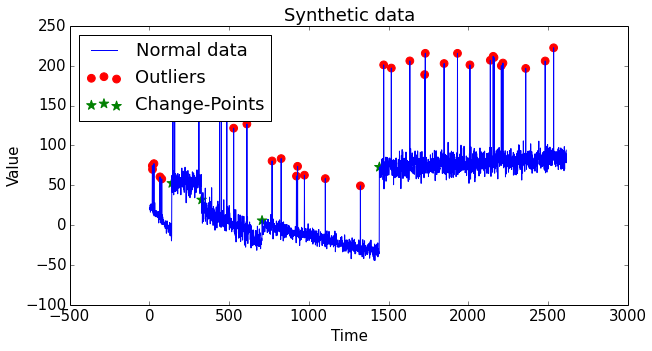

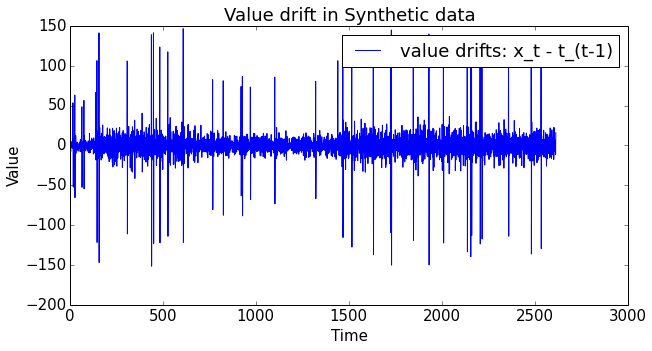

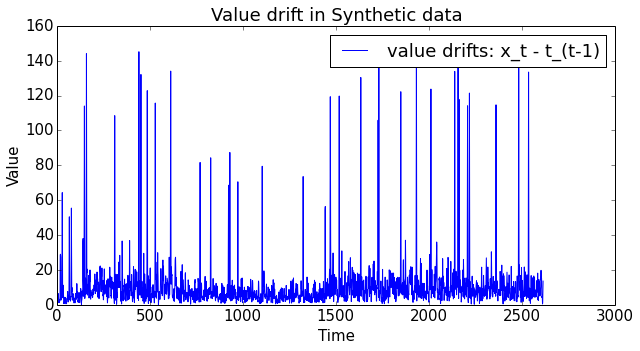

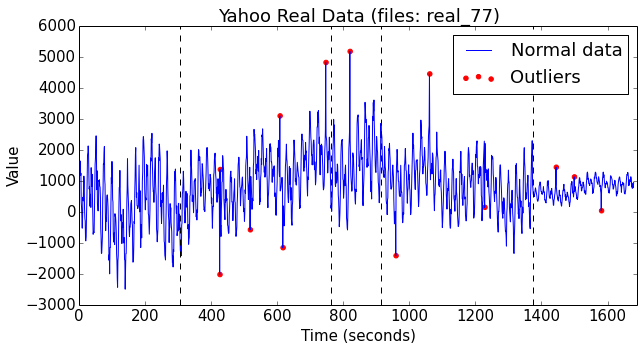

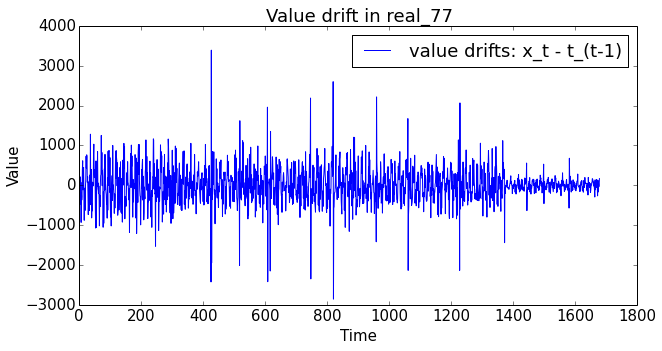

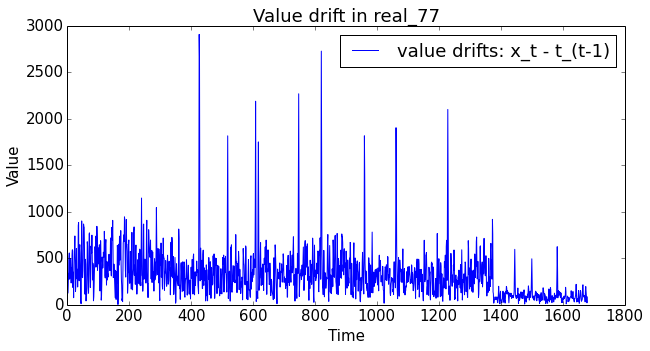

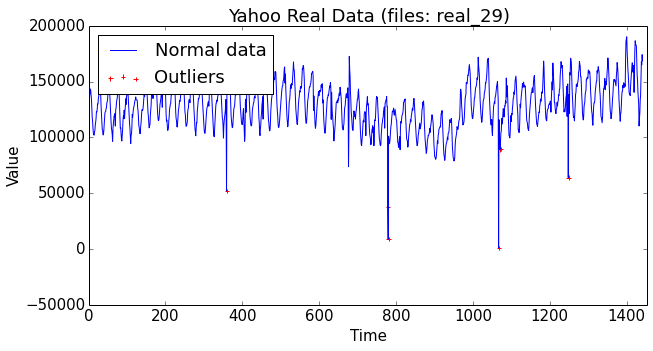

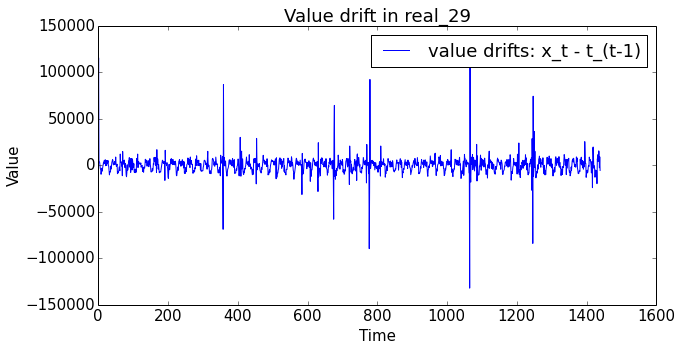

In [88]:
# load labelled data
ts_arr=[] 
tp_arr=[]
ts_flag_arr=[]
ts_cpt_arr=[]
yrange_arr=[]


dataset_names=[ "Synthetic","YSyn", "YReal"]

# ---- synthetic data ----------
tmpdf= pd.read_csv( "/home/guo/rnn_changePoint/dataset/synthetic/"+"syn_dta_trend7.csv" ,\
                   sep=',')
col = tmpdf.columns

ts = list(tmpdf[ col[0] ])
ts = [float(i)  for i in ts]
tmp_flag= list(tmpdf[ col[2] ])

cp= tmpdf[ col[1] ]
cp = list(zip(cp, range( len(ts) )))
cp_t = [  i[1]   for i in cp if i[0]==1]
cp_val = [  ts[i] for i in cp_t]

out=tmpdf[ col[2] ]
out =list( zip(out, range( len(ts) )))
out_t = [  i[1]   for i in out if i[0]==1]
out_val = [  ts[i] for i in out_t]

plot_outlier_cp( range(len(ts)), ts, out_t, out_val, cp_t,cp_val, 'Synthetic data')

ts_arr.append(ts)
ts_flag_arr.append(tmp_flag)

ts_cpt_arr.append( cp_t  )
yrange_arr.append([-100, 250]  )
# -----------------------------------------


# YAHOO SYN
tmpts, tmpts_flag, cpt = yahooSyn_load_data_plot( 77, \
                    "/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/"+\
                        "A4Benchmark/A4Benchmark-TS")
# 77
# 85

# YAHOO REAL


ts_arr.append(tmpts)
ts_flag_arr.append(tmpts_flag)
ts_cpt_arr.append(cpt)
yrange_arr.append([-3000, 6000]  )

# -----------------------------------------

dta_folder="/home/guo/Downloads/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_"
tmpts, tmpts_flag = yahoo_load_data(29, dta_folder)

ts_arr.append(tmpts)
ts_flag_arr.append(tmpts_flag)
ts_cpt_arr.append([])
yrange_arr.append([-50000, 200000]  )


In [4]:
# block2: data pre-processing

# re-organize the data to the format for feeding into the RNN 

def extract_load_data( ts_df, st_idx, ed_idx):
    tmpdta = ts_df.iloc[st_idx: ed_idx]
    cnt= len(tmpdta)
    tmpx=[]
    tmpy=[]
    for i in range(cnt-1):
        tmpx.append( tmpdta.iloc[i].as_matrix() )
        tmpy.append( tmpdta.iloc[i+1].as_matrix() )

    return tmpx, tmpy, tmpdta.iloc[cnt-1].as_matrix()

def format_timeseries_rnn(ts):
    tmptrnx =[]
    tmptrny =[]
    
    ts_df= pd.DataFrame(ts)
    
    tmpPre = 0
    tmpCur = len(ts)
    
    tmpx,tmpy, tmpy1 = extract_load_data( ts_df, tmpPre,tmpCur)
    tmptrnx.append(tmpx)
    tmptrny.append(tmpy)
    
    # qualified format for rnn
    dtax = np.array( tmptrnx )
    dtay = np.array( tmptrny )

#     print dtax.shape, dtay.shape
    return dtax, dtay

In [5]:
# block3:  RNN configureation

hidden_neurons = 450

# learning rate
lr_val = 0.001

# all the available optimizers
sgd = SGD(lr= lr_val, momentum=0.03, decay=0.0, nesterov=True)
rms = RMSprop(lr= lr_val, rho=0.9, epsilon=1e-06)

#Keras says: it is recommended to leave the parameters of this optimizer 
# at their default values for the two optimizers below
adagrad = Adagrad(lr=0.01, epsilon=1e-06)
adadelta = Adadelta(lr=1.0,rho=0.95,epsilon=1e-06)

adam =  Adam(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
adamax = Adamax(lr= lr_val, beta_1=0.9, beta_2=0.999, epsilon=1e-08)


opt_list=[ sgd, rms, adagrad, adadelta, adam, adamax ]
opt_namelist=[ "SGD with Momentum","RMSprop","ADAGRAD","ADADELTA","ADAM","ADAMAX" ]


loss_func = "mean_squared_error"
conf_level=0.01
winsize=20
nmse_arr=[1,2,3]

In [48]:
#block4: define a function for training RNN
def test_result_plot(test_tstamp,testx, testy, testyh, method_name, ybound,\
                     dataset_name, save_bool, cp_tstamp, win_size):
#     , y_lower, y_upper
    
    fig = plt.figure()
    matplotlib.rcParams.update({'font.size': 15})
    figure_size= ( 15.4,7)
    fig.set_size_inches( figure_size )
    
    plt.title("Online Prediction by "+ method_name+ " on "+ dataset_name)
    plt.ylabel('Value')
    plt.xlabel('Time')

    plt.plot( test_tstamp, testyh, label='Prediction', color='blue', linewidth=1.8)
    plt.scatter( test_tstamp, testy, label='Truth', marker='.', color='green',\
               s=60)
#     plt.scatter( list(outlier_tdf['timestamp']),list(outlier_tdf['value']), color='red',\
#              label='Outliers')

    if len(cp_tstamp) >0:
        tmpcp= [ i  for i in cp_tstamp]
        for i in tmpcp:
            plt.axvline(x=i, color='k',ls='dashed', linewidth=2.0)

    
    plt.legend( loc='upper left',fontsize=15 )

    axes = plt.gca()
    axes.set_xlim([1, len(testx)+10])
    
    if len(ybound)!=0:
        axes.set_ylim([ ybound[0],ybound[1] ])

    cnt= len(testy)

    nmse = sqrt(sum([(testy[i]- testyh[i])*(testy[i]- testyh[i]) \
                     for i in range(cnt)])*1.0/cnt)
    print 'Normalzied MSE using '+ method_name + ' on '+ dataset_name + ': ', nmse

    if save_bool == True:
        fig.savefig('../res/figures/'+method_name+'-'+dataset_name+'.pdf',\
                format='pdf', bbox_inches='tight')
    
    return nmse

    

# -----------------------------------------------------------------------------------------
def sliding_window_statistic(cur_pos, rnn_model, winsize, dataX, dataY):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    tmpres_list=[]
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        
        tmpresi =  cur_trny - cur_pred
        
        tmpres_list.append(tmpresi)
        
        tmpmean= tmpmean+tmpresi
        tmpsq= tmpsq + tmpresi*tmpresi
    
    tmpmean= tmpmean/(winsize*1.0)
    tmpvar = sum([(tmpmean-i)**2  for i in tmpres_list])/( (winsize-1.0)*1.0) 
    
    return tmpmean, tmpvar
    

def sliding_window_features_continuous(cur_pos,rnn_model, winsize, dataX, dataY,mean,var):
    
    tmpmean =0.0
    tmpsq =0.0
    tmpvar=0.0
    
    negcnt=0
    vd_sumsq=0.0
    vd_neg_sumsq=0.0
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred
        tmpvd = abs( dataX[:,i:i+1,:][0][0][0]-dataY[:,i:i+1,:][0][0][0] ) 
        
        tmp_zval = (tmpresi- mean )*1.0 / sqrt(var)
        tmp_pro =  st.norm.cdf( tmp_zval)
        if tmp_pro> (1-conf_level) or tmp_pro< conf_level:
            negcnt=negcnt+1
            vd_neg_sumsq = vd_neg_sumsq+ tmpvd**2
        
        vd_sumsq = vd_sumsq + tmpvd**2
        
    return negcnt*1.0/winsize, vd_neg_sumsq*1.0/vd_sumsq
        
def sliding_window_features(cur_pos, rnn_model, winsize, dataX, dataY, susp_list):
    
    tmpmean =0.0
    tmpvar=0.0
    
    resi_list=[]
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_trnx= dataX[:,i:i+1,:] 
        cur_trny= dataY[:,i:i+1,:]
        
        cur_pred = rnn_model.predict_on_batch( cur_trnx )[0][0][0]
        tmpresi =  cur_trny[0][0][0] - cur_pred*1.0

        resi_list.append( tmpresi )
        
        tmpmean= tmpmean+tmpresi
    
    tmpmean= tmpmean/winsize    
    tmpvar= sum([ (i-tmpmean)**2  for i in resi_list])/( winsize )
    
#   extract features

    susp_cnt=sum(susp_list)
    
    tmparr = list(zip( range(winsize), susp_list ))
    sus_idx =  [ i[0] for i in tmparr if i[1]==1 ]
    
    lnormal= -1
    rnormal= -1
    
    rsus=-1
    
    tmpdiff=[] 
    for i in range(  cur_pos-winsize , cur_pos):
        
        cur_val= dataX[:,i:i+1,:][0][0][0] 
        
        if susp_list[ i - (cur_pos-winsize) ] ==0 :
            
            if  lnormal ==-1:
                lnormal =  i
                tmpdiff.append(  0.0  )
            else:
                tmpdiff.append(  abs(  cur_val - dataX[:,lnormal:lnormal+1,:][0][0][0] ))
                lnormal = i 
        else:
            
            rsus = i
            
            if i >= (cur_pos-winsize):
                tmpdiff.append(  abs(  cur_val - dataX[:,i-1:i,:][0][0][0]   )   )
            else:
                tmpdiff.append(  abs(  0.0  )   )
    
    
    
    
    for i in range(  cur_pos-winsize , cur_pos):
        
        tmp_dta =  cur_pos -( i - (cur_pos-winsize) ) -1 
        cur_val= dataX[:,tmp_dta:tmp_dta+1,:][0][0][0] 
        
        tmp_win = tmp_dta - (cur_pos-winsize)
        
        if susp_list[ tmp_win ] ==0:
            
            if rnormal ==-1:
                rnormal = tmp_dta
            
            else:
                
                tmpdiff[  tmp_win  ] = tmpdiff[ tmp_win ] +\
                (  abs(  cur_val - dataX[:,rnormal:rnormal+1,:][0][0][0]   )   )
                
                rnormal = tmp_dta 
        else:
            if tmp_dta <= (cur_pos-1):
                tmpdiff[tmp_win]= tmpdiff[tmp_win]+\
                (  abs(  cur_val - dataX[:,tmp_dta+1:tmp_dta+2,:][0][0][0]   )   )
            
    tmparr = list(zip( tmpdiff,susp_list  ))
    norm_diff= [i[0] for i in tmparr if i[1]==0 ]
    susp_diff= [i[0] for i in tmparr if i[1]==1]
    
    if rsus ==-1:
        tmpdiff = abs( dataX[:,cur_pos:cur_pos+1,:][0][0][0] -  \
                  dataX[:, cur_pos-1:cur_pos,:][0][0][0] )
    else:
        tmpdiff = abs( dataX[:,cur_pos:cur_pos+1,:][0][0][0] -  \
                  dataX[:, rsus:rsus+1,:][0][0][0] )
    
    return tmpmean[0], tmpvar, norm_diff, susp_diff, tmpdiff

def sliding_window_weight( susp_cnt, winsize, normDiff, suspDiff, wlambda, pnt_diff):
    
#   ---------  
    r1= susp_cnt*1.0/ winsize
    tmpweight=0.0
    
    if len(suspDiff) ==0:
        tmpweight=1.0
        
    elif len(normDiff) ==0:
        
        tmpweight=1.0
        
    else:
        r2= 1.0*sum(suspDiff)*len(normDiff)/sum(normDiff)/len(suspDiff)
        if r2<5:
            r2=0.0
            r1=1.0
        else:
            r1=0.0
            
        tmpweight = wlambda*r1 + (1.0-wlambda)*exp( -1.0*r2  )
        
# -----------
    if len(normDiff) !=0:
        
        tmpr = pnt_diff*1.0 / ( sum(normDiff)/len(normDiff) )
        
        if tmpr > weight_mag:
            tmpw = exp( -1*0.04* tmpr )
        else:
            tmpw= 1.0
        
    else:
        tmpw = 0.5
        
    return tmpweight , tmpw

# 3.70700576673e-08 0.0 16.9571172403 2 433.444865839 813.302110356

import copy
def twg_train_rnn(dtax, dtay, optimizer_config, loss_func, outlier_flag,\
                             regular_para, winLength, cp_set):
    
    
    win_size=winLength
    weight_lambda = 0.2
    weight=1.0
    win_susp=[0]*winLength
    
    timesteps =1 
    in_out_neurons = 1
    
    trn_size= dtax.shape[1]-3
    trnx = dtax 
    trny = dtay 
    
    testx=[]
    testy=[]
    testyh=[]
    test_t=[]

    rrl_model = Sequential()
    rrl_model.add(LSTM(hidden_neurons, return_sequences=True, stateful= True,\
                  batch_input_shape = (1,timesteps, in_out_neurons ) ,\
                      W_regularizer=l2( regular_para ) ))
    rrl_model.add(TimeDistributedDense(output_dim= in_out_neurons ) )
    rrl_model.add(Activation("linear")) 

    rrl_model.compile(loss= loss_func, optimizer= optimizer_config )
    
    resi_mean= trnx[:,0:1,:][0][0][0]
    resi_sqr = trnx[:,0:1,:][0][0][0]**2
    resi_var= 1.0
    resi_weight=0.6
    
    seg_cnt=1
    
    pre_susp_bool=False
    
    for i in range(trn_size):
        cur_trnx= trnx[:,i:i+1,:] 
        cur_trny= trny[:,i:i+1,:]
        
        tmp_cur_trnx = copy.deepcopy(trnx[:,i:i+1,:]) 
        tmp_cur_trny = copy.deepcopy(trny[:,i:i+1,:])
        
        weight=1.0
        
        if i< winsize+1:
            rrl_model.train_on_batch(cur_trnx,cur_trny) 
            continue
        else:
            
            cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
            tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]
        
            tmpmean, tmpvar, norm_diff, susp_diff, point_diff =sliding_window_features(i,\
                                        rrl_model, win_size, trnx, trny, win_susp)
            
            tmpweight, tmpw = sliding_window_weight( sum(win_susp), win_size, norm_diff, \
                                              susp_diff, weight_lambda, point_diff)
            
            
            testval= point_diff*1.0 / ( sum(norm_diff)/len(norm_diff) )
            
            
            curmean= resi_mean
            curvar= resi_var
            
#             curmean= tmpmean
#             curvar= tmpvar
            
            tmp_zval = (tmpresi-curmean )*1.0 / sqrt(curvar)
            tmp_pro_conve =  st.norm.cdf( tmp_zval)
            
#             print "at",i, ": ", tmpmean, tmpvar, resi_mean, resi_var
            
            if tmp_pro_conve>(1-conf_level) or tmp_pro_conve<conf_level:
                
                weight=tmpw
        
                if outlier_flag[i]==1:
                    print "outlier weight at ",i,": YES ", weight, tmpw,point_diff, \
                    sum(win_susp),\
                    sum(norm_diff), sum(susp_diff), testval
#                     ,tmp_pro_conve
                else:
                    print "suspicous points at ",i,": ", weight,tmpw,point_diff,\
            sum(win_susp),\
                    sum(norm_diff), sum(susp_diff),testval
#                 ,tmp_pro_conve
                    
                win_susp.append(1)
                win_susp.pop(0)
            
            
#             ------------------------
                pre_susp_bool=True
#                 if weight !=1.0:
#                     pre_susp_bool=True
#                 else:
#                     pre_susp_bool=False
                    
                    
            else:
                
                pre_susp_bool=False
                
                win_susp.append(0)
                win_susp.pop(0)
                
                if outlier_flag[i]==1:
                    print "outlier weight at ",i,": NO ", weight,tmpw,point_diff,\
                    sum(win_susp),\
                    sum(norm_diff), sum(susp_diff),testval
#                     ,tmp_pro_conve
                
            if i in cp_set:
                print "----------- CHANGE POINT AT -------", i,":",tmp_pro_conve,weight

#             tmp_cur_trnx[0][0][0]= tmp_cur_trnx[0][0][0]*weight
#             tmp_cur_trny[0][0][0]= tmp_cur_trny[0][0][0]*weight
        
#     bug
            rrl_model.train_on_batch(tmp_cur_trnx,tmp_cur_trny*weight) 
        
        cur_pred = rrl_model.predict_on_batch( tmp_cur_trnx )[0][0][0]
        tmpresi = tmp_cur_trny[0][0][0] - cur_pred[0]
        
#         tmpmu=  (1.0-resi_weight)* resi_mean + tmpresi
        
        resi_mean = (1.0-resi_weight)* resi_mean* seg_cnt*1.0/(seg_cnt+1)+\
                    resi_weight* tmpresi/(seg_cnt+1)
#         resi_sqr = (1.0-resi_weight)*resi_sqr*seg_cnt*1.0/(seg_cnt+1) + \
#                    resi_weight*tmpresi*tmpresi/(seg_cnt+1)
#         resi_var= resi_sqr - resi_mean* resi_mean
        
#         resi_mean = (1.0-resi_weight)* resi_mean* seg_cnt*1.0/(seg_cnt+1)+\
#                     resi_weight* tmpresi/(seg_cnt+1)
        resi_sqr = resi_sqr*seg_cnt*1.0/(seg_cnt+1) + tmpresi*tmpresi/(seg_cnt+1)
        resi_var= resi_sqr - resi_mean* resi_mean
        
        seg_cnt = seg_cnt+1    
            
        
# ------------------------------------------------
        if outlier_flag[i+2]!=1 and outlier_flag[i+1]!=1 :
            vali_testx= copy.deepcopy( trnx[:, i+1:i+2,:])
        
            if pre_susp_bool== True:
                vali_testx[0][0][0] = vali_testx[0][0][0]*0.3
            print "predictor ", i, ":", trnx[:, i+1:i+2,:][0][0][0], vali_testx[0][0][0] 
            
            pred_test = rrl_model.predict_on_batch( vali_testx )[0][0][0]
        
            testx.append( vali_testx[0][0][0] )
            testy.append( trny[:, i+1:i+2,:][0][0][0])
            testyh.append( pred_test[0]   )
            test_t.append(i+1)
# ---------------------------------------------------
#         if tmp_pro_conve>(1-conf_level) or tmp_pro_conve<conf_level:
#             pre_susp_bool= True
#         else:
#             pre_susp_bool=False
    
    return test_t, testx, testy, testyh


In [ ]:
#  choose learning rate of each appraoch for each LABELLED dataset

tmpcnt = len(ts_arr)
for dataset_idx in range(tmpcnt):
    
    print "-------------- expeirments on LABBED ", dataset_names[dataset_idx], "-------------------"
    
    dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )
    lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
# lr_vals=[ 0.003, 0.005,0.007,0.009 ]

    pred_y_lr_noise=[]
    y_noise=[]
    
    print "TWG:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        tstamp, tst_x, tst_y, tst_py = twg_train_rnn(dtax, dtay, sgd, loss_func,\
                                                         ts_flag_arr[dataset_idx],0.0001, winsize)
            
        cnt= len(tst_y)
        print len(tst_y), len(tst_py)
        nmse = sqrt(sum([(tst_y[i]- tst_py[i])*(tst_y[i]-tst_py[i]) for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse


#         -------------- expeirments on LABBED  Synthetic -------------------
# TWG:
# 3046 3046
# Normalzied MSE 0.0001 :  23.4119504476
# 3046 3046
# Normalzied MSE 0.0005 :  18.149527493
# 3046 3046
# Normalzied MSE 0.001 :  17.6702746602
# 3046 3046
# Normalzied MSE 0.005 :  19.7707885839
# 3046 3046
# Normalzied MSE 0.01 :  45.2140134258
# -------------- expeirments on LABBED  YSyn -------------------
# TWG:
# 1635 1635
# Normalzied MSE 0.0001 :  749.743414097
# 1635 1635
# Normalzied MSE 0.0005 :  630.128227945
# 1635 1635
# Normalzied MSE 0.001 :  611.919614737
# 1635 1635
# Normalzied MSE 0.005 :  562.904836746
# 1635 1635
# Normalzied MSE 0.01 :  nan
# -------------- expeirments on LABBED  YReal -------------------
# TWG:
# 1409 1409
# Normalzied MSE 0.0001 :  20925.8693399
# 1409 1409
# Normalzied MSE 0.0005 :  15923.9058889
# 1409 1409
# Normalzied MSE 0.001 :  14597.701552
# 1409 1409
# Normalzied MSE 0.005 :  28472.1835922
# 1409 1409
# Normalzied MSE 0.01 :  nan

In [ ]:
#  choose learning rate of each appraoch for each UNLABELLED dataset

tmpcnt = len(ts_arr)
for i in range(tmpcnt):
    
    print "-------------- expeirments on UNLABBED ", dataset_names[i], "-------------------"
    
    dtax, dtay = format_timeseries_rnn( ts_arr[i] )
    lr_vals=[0.0001,0.0005, 0.001, 0.005, 0.01 ]

# set of more fine learing rates 
# lr_vals=[ 0.003, 0.005,0.007,0.009 ]

    pred_y_lr_noise=[]
    y_noise=[]
    ts_flag = [0]*len( ts_arr[i] )

    print "TWG:"
    for tmp_lr in lr_vals:
        sgd = SGD(lr= tmp_lr, momentum=0.03, decay=0.0, nesterov=True)
        rl_t, rl_tst_x, rl_tst_y, rl_tst_pred_y = twg_train_rnn(dtax, dtay,\
                                            sgd, loss_func,ts_flag,0.0001,winsize)
#         (dtax, dtay, optimizer_config, loss_func, outlier_flag,\
#                              regular_para, winLength):
        
        pred_y_lr_noise.append(rl_tst_pred_y)
        y_noise.append( rl_tst_y )
    
        cnt= len(rl_tst_y)
        print len(rl_tst_y), len(rl_tst_pred_y)
        nmse = sqrt(sum([(rl_tst_y[i]- rl_tst_pred_y[i])*(rl_tst_y[i]- rl_tst_pred_y[i])\
                         for i in range(cnt)])*1.0/cnt)
        print 'Normalzied MSE '+ str(tmp_lr) +  ' : ', nmse

# -------------- expeirments on UNLABBED  House Power -------------------
# TWG:
# 1380 1380
# Normalzied MSE 0.0001 :  0.876352626461
# 1380 1380
# Normalzied MSE 0.0005 :  0.583446313838
# 1380 1380
# Normalzied MSE 0.001 :  0.469989967537
# 1380 1380
# Normalzied MSE 0.005 :  0.362551354009
# 1380 1380
# Normalzied MSE 0.01 :  0.350302892903
# -------------- expeirments on UNLABBED  Air Quality -------------------
# TWG:
# 1180 1180
# Normalzied MSE 0.0001 :  294.919329283
# 1180 1180
# Normalzied MSE 0.0005 :  222.564124426
# 1180 1180
# Normalzied MSE 0.001 :  223.93959388
# 1180 1180
# Normalzied MSE 0.005 :  246.344820809
# 1180 1180
# Normalzied MSE 0.01 :  nan
# -------------- expeirments on UNLABBED  Stock -------------------
# TWG:
# 1080 1080
# Normalzied MSE 0.0001 :  1121467603.24
# 1080 1080
# Normalzied MSE 0.0005 :  766257129.874
# 1080 1080
# Normalzied MSE 0.001 :  710660531.355
# 1080 1080
# Normalzied MSE 0.005 :  725561946.759
# 1080 1080
# Normalzied MSE 0.01 :  2380488187.63
# -------------- expeirments on UNLABBED  Accelerometer -------------------
# TWG:
# 2480 2480
# Normalzied MSE 0.0001 :  184.589717758
# 2480 2480
# Normalzied MSE 0.0005 :  99.7802160293
# 2480 2480
# Normalzied MSE 0.001 :  109.645069943
# 2480 2480
# Normalzied MSE 0.005 :  174.028138614
# 2480 2480
# Normalzied MSE 0.01 :  759.1493804
# -------------- expeirments on UNLABBED  CO2 -------------------
# TWG:
# 1979 1979
# Normalzied MSE 0.0001 :  113.022782514
# 1979 1979
# Normalzied MSE 0.0005 :  68.9042908563
# 1979 1979
# Normalzied MSE 0.001 :  66.7600529411
# 1979 1979
# Normalzied MSE 0.005 :  79.428079954
# 1979 1979
# Normalzied MSE 0.01 :  119.842265719

Normalzied MSE using TDWG on YReal:  8062.60640802


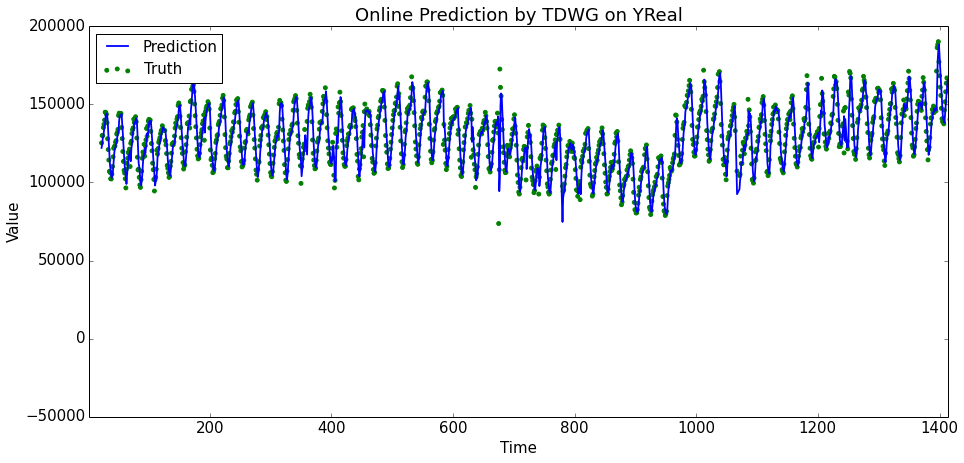

In [112]:
tmpmse=test_result_plot(tstamp, tst_x, tst_y, tst_py, "TDWG" , yrange_arr[dataset_idx], \
                 dataset_names[dataset_idx], True, ts_cpt_arr[dataset_idx], winsize)

suspicous points at  21 :  1.0 1.0 11.6666666667 0 216.5 0.0 1.07775211701
predictor  21 : 1083.25 324.975
predictor  22 : 1086.33333333 1086.33333333
predictor  23 : 1091.0 1091.0
predictor  24 : 1100.0 1100.0
predictor  25 : 1101.0 1101.0
predictor  26 : 1107.0 1107.0
predictor  27 : 1110.0 1110.0
predictor  28 : 1101.75 1101.75
predictor  29 : 1100.0 1100.0
predictor  30 : 1092.75 1092.75
predictor  31 : 1092.5 1092.5
predictor  32 : 1094.0 1094.0
predictor  33 : 1085.66666667 1085.66666667
predictor  34 : 1047.0 1047.0
predictor  35 : 1031.0 1031.0
predictor  36 : 977.5 977.5
predictor  37 : 961.25 961.25
predictor  38 : 948.0 948.0
predictor  39 : 913.25 913.25
predictor  40 : 882.5 882.5
predictor  41 : 884.5 884.5
predictor  42 : 899.0 899.0
predictor  43 : 888.25 888.25
predictor  44 : 878.5 878.5
predictor  45 : 891.25 891.25
predictor  46 : 896.5 896.5
predictor  47 : 889.5 889.5
predictor  48 : 887.333333333 887.333333333
predictor  49 : 893.5 893.5
predictor  50 : 832.5 832

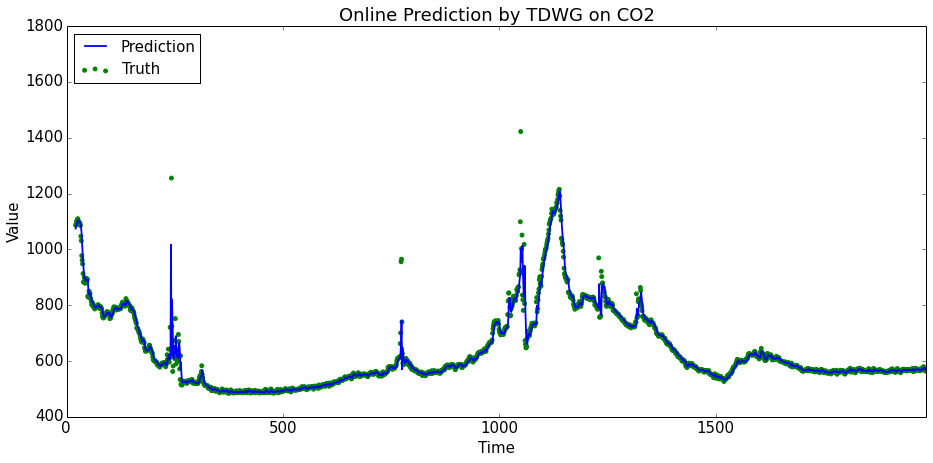

In [50]:
# block7: single run with the best learing rate
dataset_idx=4
weight_mag =3

dtax, dtay = format_timeseries_rnn( ts_arr[dataset_idx] )

sgd = SGD(lr= 0.0025, momentum=0.03, decay=0.0, nesterov=True)

tstamp, tst_x, tst_y, tst_py = twg_train_rnn(dtax, dtay, sgd, loss_func,\
                                                         ts_flag_arr[dataset_idx],0.0001,\
                                            winsize, ts_cpt_arr[dataset_idx] )

tmpmse=test_result_plot(tstamp, tst_x, tst_y, tst_py, "TDWG" , yrange_arr[dataset_idx], \
                 dataset_names[dataset_idx], False, ts_cpt_arr[dataset_idx], winsize)

nmse_arr[0]=tmpmse

#  labelled data
# lr: 
# 0.001
# 0.005
# 0.001, 0.002


# unlabelled data
# acceler: 0.002

In [29]:
#  record the results
import pickle

print dataset_names[dataset_idx]

pickle.dump(tst_x, open("../res/numeric/tdwg_x"+dataset_names[dataset_idx], "wb") )
pickle.dump(tst_y, open("../res/numeric/tdwg_y"+dataset_names[dataset_idx], "wb") )
pickle.dump(tst_py, open("../res/numeric/tdwg_py"+dataset_names[dataset_idx], "wb") )

print nmse_arr
pickle.dump(nmse_arr, open("../res/numeric/tdwg_nmse_"+dataset_names[dataset_idx], "wb") )


Accelerometer
[14.798301053964943, 2, 3]


In [17]:
# load previous results of baselines

for i in range( len(ts_arr) ):
    print pickle.load( open("../res/numeric/nmse_"+dataset_names[i], "rd") )


[17.277357262256483, 20.217691571414075, 19.914661815748207]
[562.1395347465251, 630.19864064839214, 593.28736430987192]
[17875.5193822, 15878.8205797, 11084.0161112]


In [113]:
# load previous results of TDWG

for i in range( len(ts_arr) ):
    print pickle.load( open("../res/numeric/tdwg_nmse_"+dataset_names[i], "rd") )

[9.9052467757884379, 2, 3]


IOError: [Errno 2] No such file or directory: '../res/numeric/tdwg_nmse_YSyn'